In [8]:
import numpy as np
import keras
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === Utils Functions ===
def dm2comp(dm):
    return dm[:, :, 0], dm[:, :, 1:]

def pure2dm(psi):
    ones = keras.ops.ones_like(psi[:, 0:1])
    return keras.ops.concatenate((ones[:, np.newaxis, :], psi[:, np.newaxis, :]), axis=2)

def dm_rbf_loglik(x, dm, sigma):
    d = keras.ops.shape(x)[-1]
    w, v = dm2comp(dm)
    dist = keras.ops.sum((x[:, np.newaxis, :] - v) ** 2, axis=-1)
    ll = keras.ops.log(
        keras.ops.einsum('...i,...i->...',
                        w,
                        keras.ops.exp(-dist / (2 * sigma ** 2)) ** 2)
        + 1e-12)
    coeff = d * keras.ops.log(sigma + 1e-12) + d * np.log(np.pi) / 2
    return ll - coeff

def dm_rbf_expectation(dm):
    w, v = dm2comp(dm)
    return keras.ops.einsum('...i,...ij->...j', w, v)

def dm_rbf_variance(dm, sigma):
    sigma_adj = sigma / keras.ops.sqrt(2)
    w, v = dm2comp(dm)
    d = keras.ops.shape(v)[-1]
    sq_norms = keras.ops.sum(v ** 2, axis=-1)
    w_sq = keras.ops.einsum('...i,...i->...', w, sq_norms)
    means = keras.ops.einsum('...i,...ij->...j', w, v)
    sq_means = keras.ops.sum(means ** 2, axis=-1)
    between = w_sq - sq_means
    return between + d * (sigma_adj ** 2)

def gauss_entropy_lb(d, sigma):
    return (d / 2.0) * (1.0 + keras.ops.log(2.0 * np.pi * (sigma ** 2)))

def l1_loss(vals):
    bsize = keras.ops.cast(keras.ops.shape(vals)[0], dtype=keras.float32)
    norms = keras.utils.normalize(vals, order=2, axis=1)
    return keras.ops.sum(keras.ops.abs(norms)) / bsize



In [9]:
# === Kernel Layers ===
class RBFKernelLayer(keras.layers.Layer):
    def __init__(self, sigma, dim, trainable=True, min_sigma=1e-3, **kwargs):
        super().__init__(**kwargs)
        self.sigma = self.add_weight(shape=(), initializer=keras.initializers.Constant(sigma), trainable=trainable)
        self.dim = dim
        self.min_sigma = min_sigma
    def call(self, A, B):
        a_shape = keras.ops.shape(A)
        b_shape = keras.ops.shape(B)
        A2 = keras.ops.sum(A**2, axis=-1)[..., np.newaxis]
        B2 = keras.ops.sum(B**2, axis=-1)[np.newaxis, np.newaxis, :]
        Aflat = keras.ops.reshape(A, [-1, a_shape[2]])
        AB = keras.ops.reshape(keras.ops.matmul(Aflat, keras.ops.transpose(B)), [a_shape[0], a_shape[1], b_shape[0]])
        dist2 = keras.ops.clip(A2 + B2 - 2*AB, 0., np.inf)
        self.sigma.assign(keras.ops.clip(self.sigma, self.min_sigma, np.inf))
        return keras.ops.exp(-dist2/(2.*self.sigma**2))
    def log_weight(self):
        s = keras.ops.clip(self.sigma, self.min_sigma, np.inf)
        return -self.dim*keras.ops.log(s+1e-12) - self.dim*np.log(4*np.pi)

class KDMLayer(keras.layers.Layer):
    def __init__(self, kernel, dim_x, dim_y, x_train=True, y_train=True, w_train=True, n_comp=0, l1_x=0., l1_y=0., l1_act=0., generative=0., **kwargs):
        super().__init__(**kwargs)
        self.kernel, self.dim_x, self.dim_y = kernel, dim_x, dim_y
        self.x_train, self.y_train, self.w_train = x_train, y_train, w_train
        self.n_comp, self.l1_x, self.l1_y, self.l1_act, self.generative = n_comp, l1_x, l1_y, l1_act, generative
        self.c_x = self.add_weight(shape=(n_comp, dim_x), initializer=keras.initializers.random_normal(), trainable=x_train)
        self.c_y = self.add_weight(shape=(n_comp, dim_y), initializer=keras.initializers.Constant(np.sqrt(1./dim_y)), trainable=y_train)
        self.c_w = self.add_weight(shape=(n_comp,), initializer=keras.initializers.constant(1./n_comp), trainable=w_train)
        self.eps = 1e-12
    def call(self, inputs):
        if self.l1_x: self.add_loss(self.l1_x*l1_loss(self.c_x))
        if self.l1_y: self.add_loss(self.l1_y*l1_loss(self.c_y))
        cw = keras.ops.abs(self.c_w)
        cw_sum = keras.ops.clip(keras.ops.sum(cw), self.eps, np.inf)
        self.c_w.assign(cw/cw_sum)
        w_in = inputs[...,0]; v_in = inputs[...,1:]
        vw = self.kernel(v_in, self.c_x)
        out_w = cw[np.newaxis,np.newaxis,:]*keras.ops.square(vw)
        if self.generative:
            proj = keras.ops.einsum('...i,...ij->...', w_in, out_w)
            lp = keras.ops.log(proj+self.eps)+self.kernel.log_weight()
            self.add_loss(-self.generative*keras.ops.mean(lp))
        out_w = keras.ops.maximum(out_w, self.eps)
        out_w = out_w/keras.ops.sum(out_w,axis=2,keepdims=True)
        out_w = keras.ops.einsum('...i,...ij->...j', w_in, out_w)
        if self.l1_act: self.add_loss(self.l1_act*l1_loss(out_w))
        out_w = out_w[...,np.newaxis]
        b = keras.ops.shape(out_w)[0]
        y_out = keras.ops.broadcast_to(self.c_y[np.newaxis,...],[b,self.n_comp,self.dim_y])
        return keras.ops.concatenate((out_w,y_out), axis=2)

class KDMRegressModel(keras.Model):
    def __init__(self, enc_size, dim_y, encoder, n_comp, sigma_x=0.1, min_sigma_x=1e-3, sigma_y=0.1, min_sigma_y=1e-3, generative=0., entropy_reg_x=0., sigma_x_trainable=True, sigma_y_trainable=True, **kwargs):
        super().__init__(**kwargs)
        self.encoder, self.entropy_reg_x = encoder, entropy_reg_x
        self.dim_y, self.enc_size, self.n_comp = dim_y, enc_size, n_comp
        if generative>0: encoder.trainable=False
        self.kernel = RBFKernelLayer(sigma_x, enc_size, sigma_x_trainable, min_sigma_x)
        self.kdm = KDMLayer(self.kernel, enc_size, dim_y, True, True, True, n_comp, 0., 0., 0., generative)
        self.sigma_y = self.add_weight(shape=(), initializer=keras.initializers.constant(sigma_y), trainable=sigma_y_trainable)
        self.min_sigma_y = min_sigma_y
    def call(self, x):
        rho_x = pure2dm(self.encoder(x))
        rho_y = self.kdm(rho_x)
        self.sigma_y.assign(keras.ops.clip(self.sigma_y,self.min_sigma_y,np.inf))
        return rho_y
    def predict_reg(self, x, **kw):
        rho = self.predict(x, **kw)
        return keras.ops.convert_to_numpy(dm_rbf_expectation(rho)), keras.ops.convert_to_numpy(dm_rbf_variance(rho,self.sigma_y))
    def get_sigmas(self):
        return keras.ops.convert_to_numpy(self.kernel.sigma), keras.ops.convert_to_numpy(self.sigma_y)
    def init_components(self, sx, sy, init_sigma=False, sigma_mult=1):
        enc = self.encoder.predict(sx)
        if init_sigma:
            d,_=NearestNeighbors(3).fit(keras.ops.convert_to_numpy(enc)).kneighbors(keras.ops.convert_to_numpy(enc))
            self.kernel.sigma.assign(d[:,2].mean()*sigma_mult)
        self.kdm.c_x.assign(enc); self.kdm.c_y.assign(sy); self.kdm.c_w.assign(keras.ops.ones((self.n_comp,))/self.n_comp)
    def loglik(self,y,p): return -keras.ops.mean(dm_rbf_loglik(y,p,self.sigma_y))
    def compute_loss(self,x,y,p,sw,training=True):
        loss=self.loglik(y,p)
        if self.losses: loss+=keras.ops.sum(self.losses)
        if self.entropy_reg_x: loss-=self.entropy_reg_x*gauss_entropy_lb(self.enc_size,self.kernel.sigma/keras.ops.sqrt(2))
        return loss



In [10]:
# === Data Loading ===
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
# fetch Real Estate Valuation dataset
re = fetch_ucirepo(id=477)
X = re.data.features.values
y = re.data.targets.values.reshape(-1,1)

# Standardization
sc_X = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)
X = sc_X.transform(X)
y = sc_y.transform(y)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)



In [11]:
# === Model Setup ===
encoded_size = x_train.shape[1]
dim_y = y_train.shape[1]
encoder = keras.Sequential([keras.layers.Identity()])
n_comp = 100
model = KDMRegressModel(encoded_size, dim_y, encoder, n_comp,
                        sigma_x=0.5, min_sigma_x=1e-3,
                        sigma_y=0.5, min_sigma_y=0.15,
                        generative=1.0, sigma_x_trainable=False)
model.compile(optimizer=optimizers.Adam(5e-4))

# Callbacks and initialization
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
idx = np.random.RandomState(42).randint(x_train.shape[0], size=n_comp)
model.init_components(x_train[idx], y_train[idx], init_sigma=False)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 


In [12]:
# === Training ===
history = model.fit(x_train, y_train, validation_split=0.1,
                    epochs=50, batch_size=32,
                    callbacks=[early_stop], verbose=1)



Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - loss: 18.5359 - val_loss: 18.0378
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 18.5016 - val_loss: 18.0229
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 18.2287 - val_loss: 18.0141
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 18.4804 - val_loss: 18.0031
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18.4048 - val_loss: 17.9945
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 18.7886 - val_loss: 17.9894
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 18.5136 - val_loss: 17.9759
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 18.5263 - val_loss: 17.9711
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 18.4848 - val_loss: 17.9593
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 18.5576 - val_loss: 17.9608
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 18.6683 - val_loss: 17.9546
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1

In [13]:
# === Evaluation ===
# Learned sigmas
sx, sy = model.get_sigmas()
print(f"Learned sigma_x: {sx:.4f}")
print(f"Learned sigma_y: {sy:.4f}")

# Predictions and rescaling
y_pred, y_var = model.predict_reg(x_test)
y_pred_res = sc_y.inverse_transform(y_pred)
y_test_res = sc_y.inverse_transform(y_test)

# Metrics
mse = mean_squared_error(y_test_res, y_pred_res)
r2 = r2_score(y_test_res, y_pred_res)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")



Learned sigma_x: 0.5000
Learned sigma_y: 0.5226
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step
Test MSE: 50.8455
Test R²: 0.6969


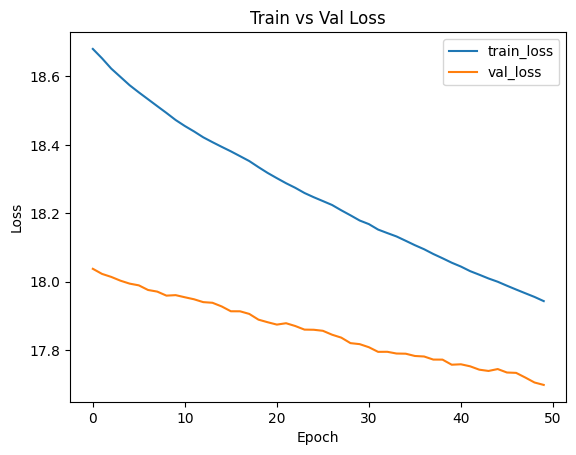

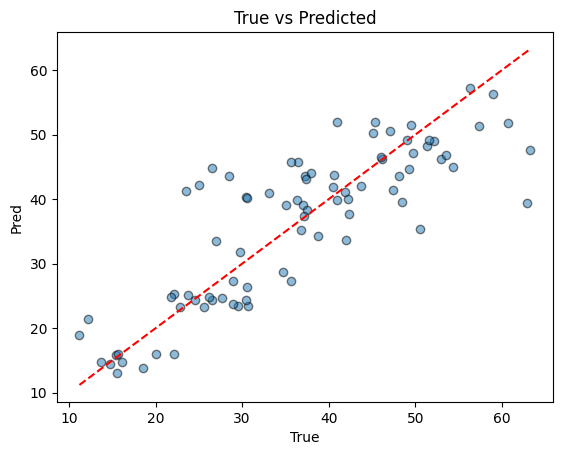

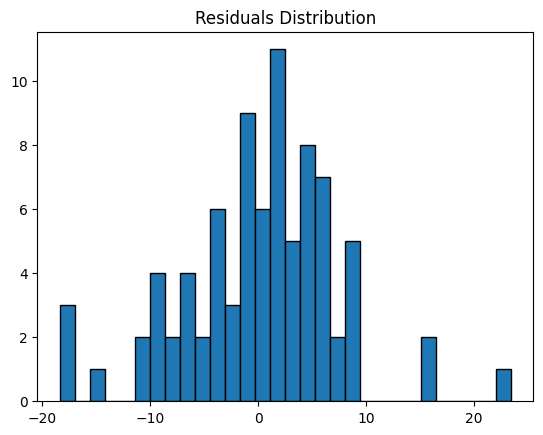

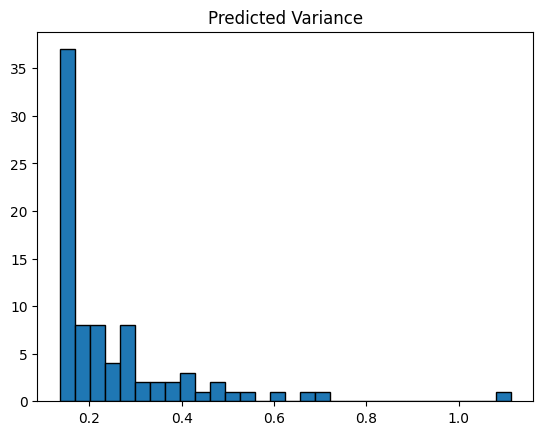

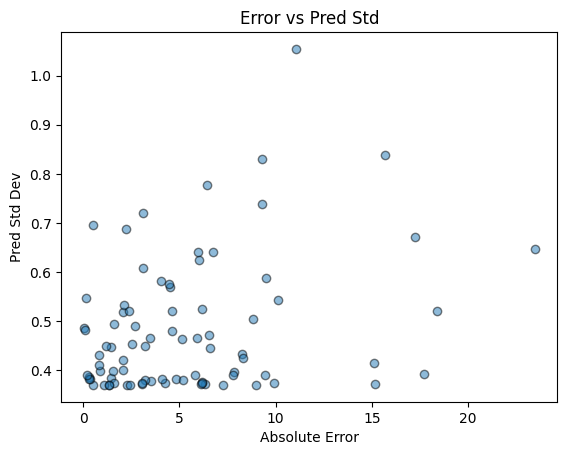

In [14]:
# === Plots ===
# Loss curves
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train vs Val Loss'); plt.legend(); plt.show()

# True vs Predicted
plt.figure()
plt.scatter(y_test_res, y_pred_res, alpha=0.5, edgecolor='k')
lims=[y_test_res.min(), y_test_res.max()]
plt.plot(lims, lims, 'r--'); plt.xlabel('True'); plt.ylabel('Pred'); plt.title('True vs Predicted'); plt.show()

# Residuals histogram
res = y_test_res - y_pred_res
plt.figure()
plt.hist(res.flatten(), bins=30, edgecolor='k')
plt.title('Residuals Distribution'); plt.show()

# Variance histogram
plt.figure()
plt.hist(y_var.flatten(), bins=30, edgecolor='k')
plt.title('Predicted Variance'); plt.show()

# Error vs Pred Std Dev
plt.figure()
plt.scatter(np.abs(res.flatten()), np.sqrt(y_var.flatten()), alpha=0.5, edgecolor='k')
plt.xlabel('Absolute Error'); plt.ylabel('Pred Std Dev'); plt.title('Error vs Pred Std'); plt.show()
